### Preparing HDFS
Using magic

Create input folder on HDFS if not exists

Copy from data from local

<span style="color:red"><em style=font-size:40px;>!</em>The following cells are  a copy and paste of our assessment 1 submission

In [1]:
!pwd
! hadoop fs -rm -R /tmp/rs_input
! hadoop fs -mkdir -p  /tmp/rs_input
! hadoop fs -put   -p  ./../data-raw/Melbourne_housing_FULL.csv             /tmp/rs_input/raw.csv
! hadoop fs -ls        /tmp/rs_input/

/home/big-data-realestate-master/scripts

20/06/07 13:16:47 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.


Deleted /tmp/rs_input


Found 1 items


-rwxrwxrwx   1 1000 staff    5018236 2020-06-07 06:53 /tmp/rs_input/raw.csv




In [2]:
//load raw into df
val df_raw = spark
    .read
    .format("csv")
    .option("header", "true")
    .load("hdfs://localhost:9000/tmp/rs_input/raw.csv")

Intitializing Scala interpreter ...

Spark Web UI available at http://a56a95a92af2:4041
SparkContext available as 'sc' (version = 2.4.5, master = local[*], app id = local-1591535816132)
SparkSession available as 'spark'


df_raw: org.apache.spark.sql.DataFrame = [Suburb: string, Address: string ... 19 more fields]


In [3]:
//only select columns we need now
var df_working= df_raw.select("Price",
                          "Method",
                          "Type",
                          "Distance",
                          "Rooms",
                          "Bathroom",
                          "Car",
                          "Landsize",
                          "Lattitude",
                          "Longtitude",    
                          "Suburb",
                          "Address",
                          "Date")


//add meaningful to column names
df_working = df_working.withColumnRenamed("Method","MethodOfSale")
    .withColumnRenamed("Distance","DistanceFromCBD")
    .withColumnRenamed("Type","PropertyType")
    .withColumnRenamed("Lattitude","Latitude")

df_working: org.apache.spark.sql.DataFrame = [Price: string, MethodOfSale: string ... 11 more fields]
df_working: org.apache.spark.sql.DataFrame = [Price: string, MethodOfSale: string ... 11 more fields]


In [4]:
//when profiling there are a number of columns with a "#N/A" which need to be removed
df_working = df_working.filter($"DistanceFromCBD" =!= "#N/A")

df_working: org.apache.spark.sql.DataFrame = [Price: string, MethodOfSale: string ... 11 more fields]


In [5]:
//refactored to remove the for column loop
df_working = df_working.withColumn("Price",col("Price").cast("Double"))
    .withColumn("Rooms",col("Rooms").cast("Int"))
    .withColumn("DistanceFromCBD",col("DistanceFromCBD").cast("Double"))
    .withColumn("Bathroom",col("Bathroom").cast("Int"))
    .withColumn("Car",col("Car").cast("Int"))
    .withColumn("Landsize",col("Landsize").cast("Double"))
    .withColumn("Latitude",col("Latitude").cast("Double"))
    .withColumn("Longtitude",col("Longtitude").cast("Double"))
    

df_working: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: string ... 11 more fields]


In [6]:
//convert categorically values to ints
//make sure the categorical type is upper
df_working = df_working.withColumn("PropertyType", upper(col("PropertyType")))

df_working = df_working.withColumn("PropertyType",
when(col("PropertyType") === "H", "1")
.when(col("PropertyType") === "U", "2")
.when(col("PropertyType") ==="T", "3")
.otherwise("0"))

df_working: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: string ... 11 more fields]
df_working: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: string ... 11 more fields]


In [7]:
//convert categorically values to ints
//make sure the categorical type is upper
df_working = df_working.withColumn("MethodOfSale", upper(col("MethodOfSale")))

df_working: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: string ... 11 more fields]


In [8]:
df_working = df_working.withColumn("MethodOfSale",
when(col("MethodOfSale") === "S", "1")
.when(col("MethodOfSale") === "SP", "2")
.when(col("MethodOfSale") === "PI", "3")
.when(col("MethodOfSale") === "PN", "4")
.when(col("MethodOfSale") === "SN", "5")
.when(col("MethodOfSale") === "VB", "6")
.when(col("MethodOfSale") === "W", "7")
.when(col("MethodOfSale") === "SA", "8")
.when(col("MethodOfSale") === "SS", "9")                                
.otherwise("0"))

df_working: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: string ... 11 more fields]


In [9]:
//cast categorical values to Ints
//Not strictly needed with the one hot encoding later
df_working = df_working.withColumn("PropertyType",col("PropertyType").cast("Int"))
    .withColumn("MethodOfSale",col("MethodOfSale").cast("Int"))

df_working: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: int ... 11 more fields]


In [10]:
// make first letter of suburb upper case
df_working= df_working.withColumn("Suburb", initcap(col("Suburb")))

df_working: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: int ... 11 more fields]


In [11]:
//split address on Street name and Suffix
df_working = df_working.withColumn("StreetName",split(col("Address")," ").getItem(1)).
    withColumn("StreetSuffix",split(col("Address")," ").getItem(2)).drop("Address")

df_working: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: int ... 12 more fields]


In [12]:
//fix "The Parade, The *** adddresses"
df_working = df_working.withColumn("StreetName",
when(col("StreetName").like("The"), concat(lit("The "),col("StreetSuffix")))
.otherwise(col("StreetName")))

//remove the street suffix
df_working = df_working.withColumn("StreetSuffix",
when(col("StreetName").contains("The"), lit(""))
.otherwise(col("StreetSuffix")))

df_working: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: int ... 12 more fields]
df_working: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: int ... 12 more fields]


In [13]:
//Rebuild street name from cleaned tokens
//this is approach was due to the legacy code we already had tokenizing the address so i just rejoined them
//one could write a regex replace to remove the street numbers unit numbers etc. bu i know these columns are clean
df_working = df_working.withColumn("StreetName", concat(col("StreetName"), lit(" "),col("StreetSuffix"))).drop("StreetSuffix")

df_working: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: int ... 11 more fields]


In [14]:
// make first letter of Street upper case
df_working= df_working.withColumn("StreetName", initcap(col("StreetName")))

df_working: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: int ... 11 more fields]


In [15]:
//drop all properties with land area less than 12 sqm 
df_working = df_working.filter(!($"Landsize"<12))

df_working: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: int ... 11 more fields]


In [16]:
//drop rows where type = h and landsize < 50 sqm
df_working = df_working.filter(!($"Landsize"<50 && $"PropertyType"===1))

df_working: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: int ... 11 more fields]


In [17]:
val df_not_null = df_working.na.drop()

df_not_null: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: int ... 11 more fields]


In [18]:
df_not_null.printSchema()

root
 |-- Price: double (nullable = true)
 |-- MethodOfSale: integer (nullable = true)
 |-- PropertyType: integer (nullable = true)
 |-- DistanceFromCBD: double (nullable = true)
 |-- Rooms: integer (nullable = true)
 |-- Bathroom: integer (nullable = true)
 |-- Car: integer (nullable = true)
 |-- Landsize: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longtitude: double (nullable = true)
 |-- Suburb: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- StreetName: string (nullable = true)



In [19]:
! hadoop fs -rm -R /tmp/output
! hadoop fs -mkdir -p /tmp/output

20/06/07 13:17:13 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.


Deleted /tmp/output




In [20]:
//this coalesce and write out isn't necessary if doing e2e
val df_output = df_not_null.coalesce(1)
   .write
   .format("csv")
   .option("header","true")
   .mode("overwrite").option("sep",",")
   .save("hdfs://localhost:9000/tmp/output")

df_output: Unit = ()


In [21]:
! hadoop fs -mkdir -p /tmp/output
! rm ./../data-clean/cleanMelbourneData.csv
! hadoop fs -copyToLocal /tmp/output/\*.csv ./../data-clean/cleanMelbourneData.csv

##  <span style="color:red"><em style=font-size:40px;>!</em>Assessment 2 Modelling etc. Starts from here


## Import Data
Here you have the option to just start from the outputed file from the wrangling if that has been ran before. 
Or can go e2e

I think ideally we would want to move from output to a new input folder somewhere on HDFS

In [22]:
//use the set wrangled from above
var df_clean = df_not_null

df_clean: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: int ... 11 more fields]


### Load from saved local file

ctrl + / or cmd + / should can comment / uncomment selections

In [23]:
! hadoop fs -mkdir -p  /tmp/output
! hadoop fs -put   -p  ./../data-clean/cleanMelbourneData.csv  /tmp/output  

In [24]:
// Load Clean Dataset into a DataFrame from HDFS after wrangling is completed
var df_clean = spark
    .read
    .format("csv")
    .option("header", "true")
    .load("hdfs://localhost:9000/tmp/input/*.csv")
df_clean.cache()

//when we use the output from the wrangle 
//this can be removed as types should be fine
df_clean = df_clean.withColumn("Price",col("Price").cast("Double"))
    .withColumn("Rooms",col("Rooms").cast("Int"))
    .withColumn("DistanceFromCBD",col("DistanceFromCBD").cast("Double"))
    .withColumn("MethodOfSale",col("MethodOfSale").cast("Int"))
    .withColumn("PropertyType",col("PropertyType").cast("Int"))
    .withColumn("Bathroom",col("Bathroom").cast("Int"))
    .withColumn("Car",col("Car").cast("Int"))
    .withColumn("Landsize",col("Landsize").cast("Double"))
    .withColumn("Latitude",col("Latitude").cast("Double"))
    .withColumn("Longtitude",col("Longtitude").cast("Double"))


df_clean: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: int ... 11 more fields]
df_clean: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: int ... 11 more fields]


In [25]:
//debug check file load
df_clean.cache()
df_clean.printSchema()
df_clean.count()

root
 |-- Price: double (nullable = true)
 |-- MethodOfSale: integer (nullable = true)
 |-- PropertyType: integer (nullable = true)
 |-- DistanceFromCBD: double (nullable = true)
 |-- Rooms: integer (nullable = true)
 |-- Bathroom: integer (nullable = true)
 |-- Car: integer (nullable = true)
 |-- Landsize: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longtitude: double (nullable = true)
 |-- Suburb: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- StreetName: string (nullable = true)



res1: Long = 15728


 ### Check Spark Parameters

In [26]:
import org.apache.spark.sql.SparkSession
import org.apache.spark.{SparkConf,SparkContext}

// Set log level to ERROR (less verbose)
sc.setLogLevel("WARN")
val cs = spark.sparkContext.getConf
sc.getConf.toDebugString



import org.apache.spark.sql.SparkSession
import org.apache.spark.{SparkConf, SparkContext}
cs: org.apache.spark.SparkConf = org.apache.spark.SparkConf@73482db5
res2: String =
spark.app.id=local-1591535816132
spark.app.name=spylon-kernel
spark.driver.host=a56a95a92af2
spark.driver.port=40185
spark.executor.id=driver
spark.master=local[*]
spark.rdd.compress=True
spark.repl.class.outputDir=/tmp/tmpebateiix
spark.repl.class.uri=spark://a56a95a92af2:40185/classes
spark.serializer.objectStreamReset=100
spark.submit.deployMode=client
spark.ui.showConsoleProgress=true


### Construct vectors from attributes
#### Transform Sale Date into a numeric value

In [27]:
df_clean = df_clean.withColumn("Date",unix_timestamp($"Date", "dd/mm/yyyy"))

df_clean: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: int ... 11 more fields]


In [65]:
import org.apache.spark.ml.feature.{FeatureHasher,StandardScaler,OneHotEncoder,VectorAssembler}
import org.apache.spark.ml.feature.OneHotEncoderEstimator
import org.apache.spark.ml.feature.StringIndexer
import org.apache.spark.ml.feature.VectorIndexer
import org.apache.spark.ml.linalg.Vectors


//set the feature names
val featureColumnNames= Array("MethodOfSale",
            "PropertyType",
            "DistanceFromCBD",
            "Rooms",
            "Bathroom",
            "Car",
            "Landsize",
            "Latitude",
            "Longtitude",
            "SuburbIndex",
            "Date",
            "StreetNameIndex")

//set the categorical names
val categoricalFeatureColumnNames= Array("MethodOfSale",
            "PropertyType",
            "SuburbIndex",
            "StreetNameIndex")

//set the categorical names after encoding
//used by the assembler
val EncodedCategoricalFeatureColumnNames = Array("MethodOfSalecategoryVec1",
            "PropertyTypecategoryVec2",
            "DistanceFromCBD",
            "Rooms",
            "Bathroom",
            "Car",
            "Landsize",
            "Latitude",
            "Longtitude",
            "SuburbIndexcategoryVec3",
            "Date",
            "StreetNameIndexSuburbIndexcategoryVec4")


//define feature hasher for Linear Regressoin
val featureHasher = new FeatureHasher()
    .setInputCols(featureColumnNames)
    .setCategoricalCols(categoricalFeatureColumnNames)
    .setOutputCol("hashedFeatures")


//define string indexers
val suburbIndexer = new StringIndexer()
    .setInputCol("Suburb")
    .setOutputCol("SuburbIndex")
    .setHandleInvalid("keep")

val streetNameIndexer = new StringIndexer()
    .setInputCol("StreetName")
    .setOutputCol("StreetNameIndex")
    .setHandleInvalid("keep")


//define assmebler
val assembler = new VectorAssembler()
    .setInputCols(EncodedCategoricalFeatureColumnNames)
    .setOutputCol("features")

//define indexer 
val indexer = new VectorIndexer()
    .setInputCol("features")
    .setOutputCol("indexedFeatures")
    .setMaxCategories(1298) //number of distinct streetnames
    .setHandleInvalid("keep")

// one hot encoder
val allEncoder = new OneHotEncoderEstimator()
  .setInputCols(Array("MethodOfSale",
                      "PropertyType",
                      "SuburbIndex",
                      "StreetNameIndex"))
  .setOutputCols(Array("MethodOfSalecategoryVec1",
                       "PropertyTypecategoryVec2",
                       "SuburbIndexcategoryVec3",
                       "StreetNameIndexSuburbIndexcategoryVec4"))


//define scaler 
val scaler = new StandardScaler()
      .setInputCol("features")
      .setOutputCol("scaledFeatures")
      .setWithStd(true).setWithMean(true)

import org.apache.spark.ml.feature.{FeatureHasher, StandardScaler, OneHotEncoder, VectorAssembler}
import org.apache.spark.ml.feature.OneHotEncoderEstimator
import org.apache.spark.ml.feature.StringIndexer
import org.apache.spark.ml.feature.VectorIndexer
import org.apache.spark.ml.linalg.Vectors
featureColumnNames: Array[String] = Array(MethodOfSale, PropertyType, DistanceFromCBD, Rooms, Bathroom, Car, Landsize, Latitude, Longtitude, SuburbIndex, Date, StreetNameIndex)
categoricalFeatureColumnNames: Array[String] = Array(MethodOfSale, PropertyType, SuburbIndex, StreetNameIndex)
EncodedCategoricalFeatureColumnNames: Array[String] = Array(MethodOfSalecategoryVec1, PropertyTypecategoryVec2, DistanceFromCBD, Rooms, Bathroom, Car, Landsize, Latitude, Longtitude, SuburbIndexcategoryVec3, Date...

### Apply Log transformation to price

In [29]:
df_clean = df_clean.withColumn("loggedPrice", log($"Price").cast("Double"))

df_clean: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: int ... 12 more fields]


In [30]:
df_clean.select("loggedPrice").show(4)

+------------------+
|       loggedPrice|
+------------------+
|14.207552645740298|
|13.849911984681606|
|14.197365800433305|
|13.652991628466498|
+------------------+
only showing top 4 rows



In [31]:
//check the antilog - introduces a slight rounding error
//could fix in future
df_clean.withColumn("PriceAntilog", exp((col("loggedPrice")))).select("Price","PriceAntilog").show(10)

+---------+------------------+
|    Price|      PriceAntilog|
+---------+------------------+
|1480000.0|1480000.0000000007|
|1035000.0|1034999.9999999997|
|1465000.0|1465000.0000000005|
| 850000.0| 849999.9999999994|
|1600000.0| 1600000.000000001|
| 941000.0| 940999.9999999994|
|1876000.0|1876000.0000000012|
|1636000.0| 1635999.999999999|
|1097000.0|1096999.9999999995|
|1350000.0|1350000.0000000002|
+---------+------------------+
only showing top 10 rows



### Split Data into a Training and a Testing Set

In [32]:
df_clean.toDF.createOrReplaceTempView("df_py_clean")

In [33]:
%%python
df_clean_p = spark.sql("select * from df_py_clean")
df_clean_p.show(5)

+---------+------------+------------+---------------+-----+--------+---+--------+--------+----------+----------+----------+-------------+------------------+
|    Price|MethodOfSale|PropertyType|DistanceFromCBD|Rooms|Bathroom|Car|Landsize|Latitude|Longtitude|    Suburb|      Date|   StreetName|       loggedPrice|
+---------+------------+------------+---------------+-----+--------+---+--------+--------+----------+----------+----------+-------------+------------------+
|1480000.0|           1|           1|            2.5|    2|       1|  1|   202.0|-37.7996|  144.9984|Abbotsford|1451779920|    Turner St|14.207552645740298|
|1035000.0|           1|           1|            2.5|    2|       1|  0|   156.0|-37.8079|  144.9934|Abbotsford|1451865720| Bloomburg St|13.849911984681606|
|1465000.0|           2|           1|            2.5|    3|       2|  0|   134.0|-37.8093|  144.9944|Abbotsford|1483488180|   Charles St|14.197365800433305|
| 850000.0|           3|           1|            2.5|    3

In [34]:
! pip install matplotlib
! pip install pandas














You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.










You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.



<IPython.core.display.Javascript object>


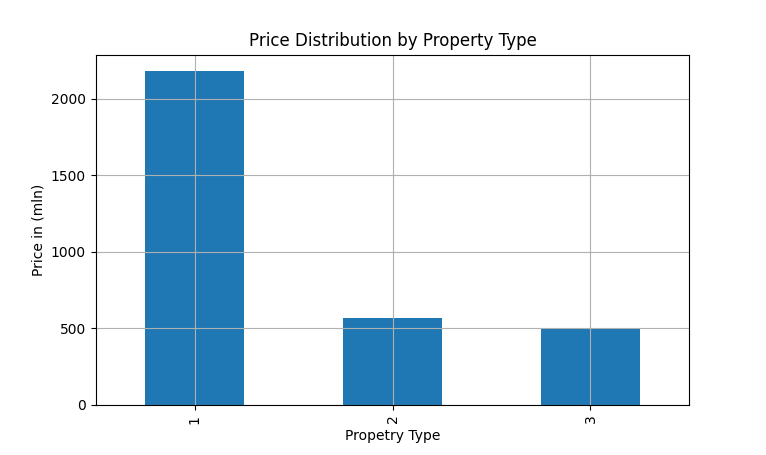

In [35]:
%matplotlib notebook 
%%python

import pandas as pd
import matplotlib.pyplot as plt

df_clean_pd = df_clean_p.toPandas() 

# 1 -House, 2- Unit, 3 -Townhouse
ax = df_clean_pd.groupby("PropertyType")["Price"].nunique().plot(kind="bar")
ax.set_ylabel("Price in (mln)")
ax.set_xlabel("Propetry Type")
plt.grid()
plt.title("Price Distribution by Property Type")
plt.show()

In [36]:
//define function to take a data frame and set training and test samples
//stratafied sample on propertype type
//original random sample may have been skewing the model
//used propertype as the prices vary wildly based on the type 

//idea is split into training and testing - then stratify the training set so its balanced.

//https://maet3608.github.io/nuts-ml/tutorial/split_stratify.html#id1

import org.apache.spark.sql.DataFrame
import org.apache.spark.sql.functions._


def train_test_split(data: DataFrame) = {
    
    //split into 80% 20%
    var Array(train, test) = data.randomSplit(Array(0.8, 0.2), seed = 30)
    
    //Stratified sampler
    //want to over sample the other propertyTypes
    val fractions = Map(1 -> 0.8,2 ->0.9, 3 -> 0.9)

     train = train.stat.sampleBy("PropertyType",fractions,36L)
    
    (train, test)
}

val (train, test) = train_test_split(df_clean)

train.cache()
test.cache()

//debug sample counts
//println(train.count())
//println(test.count())

import org.apache.spark.sql.DataFrame
import org.apache.spark.sql.functions._
train_test_split: (data: org.apache.spark.sql.DataFrame)(org.apache.spark.sql.Dataset[org.apache.spark.sql.Row], org.apache.spark.sql.Dataset[org.apache.spark.sql.Row])
train: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [Price: double, MethodOfSale: int ... 12 more fields]
test: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [Price: double, MethodOfSale: int ... 12 more fields]
res6: test.type = [Price: double, MethodOfSale: int ... 12 more fields]


### 1. Apply Linear Regression


###  Useful Specs for this section 

Feel free to move to references i guess

https://spark.apache.org/docs/latest/api/scala/index.html#org.apache.spark.ml.regression.LinearRegression

https://spark.apache.org/docs/latest/api/scala/index.html#org.apache.spark.ml.tuning.ParamGridBuilder

https://spark.apache.org/docs/latest/api/scala/index.html#org.apache.spark.ml.feature.FeatureHasher

https://spark.apache.org/docs/latest/ml-classification-regression.html#linear-regression

https://spark.apache.org/docs/latest/mllib-evaluation-metrics.html#regression-model-evaluation

https://spark.apache.org/docs/1.6.2/api/java/org/apache/spark/sql/DataFrameStatFunctions.html#sampleBy(java.lang.String,%20java.util.Map,%20long)


In [37]:
//imports for linear regression code in one spot
//to be moved with other imports to start
import org.apache.spark.ml.regression.LinearRegression
import org.apache.spark.ml.evaluation.RegressionEvaluator
import org.apache.spark.ml.tuning.{CrossValidator, ParamGridBuilder}
import org.apache.spark.ml.param.ParamMap
import org.apache.spark.ml.Pipeline

import org.apache.spark.ml.regression.LinearRegression
import org.apache.spark.ml.evaluation.RegressionEvaluator
import org.apache.spark.ml.tuning.{CrossValidator, ParamGridBuilder}
import org.apache.spark.ml.param.ParamMap
import org.apache.spark.ml.Pipeline


In [38]:
//function for getting execution time from start and end times
def getExecutionTime(start: Long , end : Long) = {
    val duration:Long = (end - start) / 1000
    (duration)
}

getExecutionTime: (start: Long, end: Long)Long


### Run first LR model with default Params
Assess the training set

In [39]:
val startTimeMillis = System.currentTimeMillis()

//just give a LR a go with default settings values
val lr = new LinearRegression()
    .setLabelCol("loggedPrice")
    .setFeaturesCol("hashedFeatures")
    .setPredictionCol("Predicted loggedPrice")
    .setMaxIter(1500)

//make a dataset for testing the model and printing its summarry
//could be made into a pipeline
val suburbindex = suburbIndexer.fit(train).transform(train)
val allindex = streetNameIndexer.fit(suburbindex).transform(suburbindex)
val featurized = featureHasher.transform(allindex)
val lrModel = lr.fit(featurized)

// Print the coefficients and intercept for linear regression
println(s"Coefficients: ${lrModel.coefficients} Intercept: ${lrModel.intercept}")

// Summarize the model over the training set and print out some metrics
val trainingSummary = lrModel.summary

println("\n")
println(s"numIterations: ${trainingSummary.totalIterations}")
println(s"objectiveHistory: [${trainingSummary.objectiveHistory.mkString(",")}]")
println("\n")

trainingSummary.residuals.show()

println("\n")
println(s"RMSE: ${trainingSummary.rootMeanSquaredError}")
println(s"r2: ${trainingSummary.r2}")
println("\n")

//print runtime
val endTimeMillis = System.currentTimeMillis()

print("Model was executed "
      + getExecutionTime(startTimeMillis,endTimeMillis))


2020-06-07 13:17:41,260 WARN  [Thread-4] netlib.BLAS (BLAS.java:<clinit>(61)) - Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
2020-06-07 13:17:41,261 WARN  [Thread-4] netlib.BLAS (BLAS.java:<clinit>(61)) - Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Coefficients: (262144,[19,133,179,380,382,490,745,756,830,849,885,926,961,990,1077,1087,1192,1201,1225,1256,1295,1395,1405,1499,1565,1607,1690,1696,1760,1822,1872,1929,1977,2070,2106,2117,2124,2187,2256,2504,2667,2713,2848,2888,2889,2897,2957,2969,2976,2978,3046,3047,3050,3059,3204,3277,3278,3291,3322,3343,3360,3387,3397,3416,3417,3473,3490,3535,3582,3612,3708,3792,3822,3872,3994,4008,4066,4080,4110,4135,4156,4173,4246,4278,4330,4334,4372,4454,4502,4582,4822,4938,4966,4985,5113,5290,5326,5372,5582,5605,5670,5706,5722,5740,5881,6038,6228,6238,6311,6335,6367,6368,6384,6466,6471,6475,6522,6601,6649,6655,6754,6757,6871,6892,7093,7135,7181,7305,7310,7325,7353,7367,7440,7599,7610,7659,7673,7707,7718,7787,7971,7978,8038,8147,8183,8213,8243,8257,8281,8439,8451,8482,8507,8515,8593,8671,8681,8686,8712,8730,8738,8746,8785,8796,8846,8847,8928,8997,9010,9080,9089,9105,9185,9214,9229,9255,9348,9352,9392,9437,9626,9634,9663,9731,9750,9924,9957,10175,10184,10270,10271,10274,10289,10348,10393,10399,104

8413,128440,128475,128479,128494,128555,128584,128804,128818,128827,128889,128927,129013,129061,129071,129171,129213,129237,129268,129320,129365,129395,129438,129449,129700,129739,129769,129802,129829,129832,129878,129899,129952,130062,130098,130160,130254,130290,130316,130339,130345,130355,130360,130393,130421,130439,130449,130540,130589,130596,130629,130649,130650,130692,130705,130727,130813,130827,130923,130957,131012,131068,131163,131193,131308,131312,131412,131428,131439,131442,131464,131508,131515,131528,131538,131559,131653,131814,131878,131879,131895,131955,132014,132042,132070,132193,132224,132237,132346,132352,132354,132376,132377,132503,132686,132702,132752,132786,132856,132933,132938,132942,133044,133102,133130,133187,133236,133279,133297,133405,133416,133451,133512,133525,133536,133577,133635,133722,133729,133776,133797,133821,133872,133896,133957,134049,134058,134093,134245,134254,134342,134367,134403,134519,134546,134672,134680,134746,134758,134761,134882,134962,134982,1

,239435,239452,239505,239515,239525,239568,239576,239642,239644,239752,239754,239761,239782,239838,239931,239946,239969,240115,240172,240185,240235,240297,240382,240390,240422,240429,240457,240487,240584,240588,240616,240618,240658,240659,240665,240667,240689,240763,240844,240941,240952,241037,241050,241107,241257,241262,241325,241347,241394,241397,241450,241478,241479,241492,241524,241547,241593,241635,241711,241823,241857,241870,241977,241989,242059,242076,242122,242179,242204,242379,242417,242488,242549,242559,242569,242588,242640,242657,242716,242731,242746,242783,242787,242835,242859,242938,242992,243029,243048,243060,243123,243125,243148,243162,243315,243413,243417,243499,243537,243538,243645,243672,243731,243748,243751,243807,243952,243998,244022,244071,244100,244128,244194,244233,244296,244328,244385,244415,244451,244456,244461,244470,244472,244513,244539,244546,244571,244598,244600,244638,244652,244676,244724,244752,244766,244859,244869,244972,245081,245136,245243,245342,24544

88090716896604,-0.034976678866418955,-0.3063662921732319,-0.11716427734220718,-0.13489929524534242,0.04484378691812171,0.04790855658713474,0.20971304876244082,-0.04441286342375183,0.09342043728675786,-0.10578534738662511,0.142807450091704,0.062254112969645274,-4.6682848518613787E-4,-0.12057192387536914,0.2650745023713922,-0.15728863640992083,0.07360947030446857,-0.038064119318428624,-0.029410759911852814,0.04948843427495439,-0.3776593671560832,0.04418697240111588,0.03684509406421319,0.10337450555105972,0.37973240177276196,-0.14150550261847555,0.16277281561114068,0.07537403673525261,0.060354759830331804,-0.4322207976713206,-0.24771512782057759,0.23523651317863695,0.03638482263166754,0.02329795017730083,-0.05764232046869633,-0.1046313265709317,0.06662556487792774,0.14834637180264224,-0.5764163692703026,-0.023788939361485285,0.23960057742165589,0.17294951323124827,0.11207226586242278,0.15171422536661855,0.16057207550009855,0.03499556264129223,-0.12291553488038756,-0.17889447808271416,0.09

8213225221143232,-0.06811344922727855,0.2441762720806187,0.24858976847985229,0.37051266880514183,0.027074020977841663,0.04009271911643776,0.2478955554238578,-0.016702268419439635,-0.02860079555867713,-0.007256767752049309,-0.023317296792382827,-0.282301235347462,0.10950426889912677,-0.3921867499475106,-0.1793045225324982,-0.16257948672140587,0.04682210989471199,-0.07131141937981324,-0.3832363715490525,-0.39564219898084185,0.12217128358443535,-0.42816661605426204,-0.07809533965276641,-0.0921688569696927,-0.1350821885754249,0.1537917278503292,0.15435729523067,0.4501408527417938,-0.2712213836031282,-0.25316563813523274,-0.05387035577889364,0.0679369426585711,1.9521675500970146E-9,-0.08194589083423001,-0.0900104114758996,0.036219053176903444,0.25527788546463126,0.18185936242776576,0.12101466088174334,0.033278907177486085,0.1663290659138444,0.21986663589340164,-0.05551599244537083,0.34500492253481824,0.259695956049207,0.08766608445388273,0.13358448555847743,0.5066378421140502,0.106667622680

618843,-0.23776874813150053,0.11216112866968844,0.02050520046921559,-0.13583651462796892,0.3611138030976686,-0.20478810087711358,0.28157169464891957,0.39867600658558083,0.010432643383100194,-0.41400775568625053,0.03658030111984988,0.08596332494026268,-0.3375922662694007,-0.27605197435053147,0.07680256524876396,0.08492569702630458,0.6125729205922229,-0.06479488119671264,0.06387037966028357,0.022141623149742745,0.1968511646798371,-2.157165271117037,-0.03632556244616507,0.04144121560662259,0.22898032297787302,0.12272719023325225,-0.1598715595556259,-0.1570375967678477,0.07810257527712242,-0.2107793106557686,-0.11197236293278773,0.06243982351703116,0.014161555976102897,-0.09424663788617475,0.17345491380882422,-0.08433937118907217,-0.05923341512140108,-0.24960495609167407,-0.012199403303853003,0.0815543569783444,0.19208147268892856,-0.09155980123990479,0.3394919977804724,-0.4886828626957032,-0.1071563130874121,0.08093014716574438,-0.18949795727195862,-0.07832015035051884,0.3838795543840884,

-0.08167536137948933,-0.09991585896756751,-0.07402433849732086,-0.1666034823621474,-0.31529069790567577,0.19197946153833675,0.3619356523990832,0.005673089041731071,-0.11342480714470023,-0.16392763020828863,-0.08004829257612017,-0.02790300568279128,-0.037030249876162866,0.038451501659017395,0.06177013871854521,-0.3059386308676911,0.10095034512872016,0.3167732663147648,-0.32289861422552013,0.16681638367226467,0.01747320132954233,0.39364956099054715,-0.4185830575547203,-0.36426025406434803,0.18609524349998388,-0.19229369524611295,-0.6646898528092225,-0.16658696188343236,-0.08777590404517323,0.02728648036641071,0.08310038222250052,0.14153205775321134,-0.3420420367394652,-0.06675625105761585,0.04934773791764821,0.22127100473934236,0.021550478809099077,0.19776180544016297,0.2853946104441129,0.11343221550268529,-0.5371289278471423,0.09954682405124253,0.14692668685421303,0.06683002694408269,0.05156333026687266,0.11604199865332424,-0.025366155430121017,0.10733379175254179,0.009382450547034644,0

22014377687250256,-0.003023076860829484,0.28907061300555587,0.16748892743390148,-0.026843155505179222,0.46276803263577326,0.13632039482060496,0.08431237133859999,-0.03475329471485711,0.04219359428963564,-0.05333144828946636,0.20381690214622328,-0.17143225735557155,0.15085049397609196,-0.24752381662216275,-0.0872542624688599,-0.20440274332895955,0.17785294950134906,0.2343647949036451,-0.15603063790579563,0.04224551622239824,-0.015565060063505297,-0.1231760881153286,0.6072172172906781,0.5907033082282335,0.3343710436603048,0.268401163005725,-0.04143541754775633,0.01961651923379391,-0.020470368495482207,-0.15963986355233425,0.052494861436690576,-0.38070676293410144,0.06121786160251835,0.002966570844162422,0.19665629437914406,0.42349173644392074,-0.15467583325523582,0.03919848683352332,-1.3335062614609339,-0.18655359541863845,0.26019797295329955,-0.046881124629263145,0.012340044020831395,0.6463006874722832,-0.018063939276098537,0.1981979810314388,-0.39691955605181944,-0.5744784125828072,0.2

602881062817324,-0.020876326635393443,-0.25069122005731853,-0.24139334275577598,0.06513270347144982,-0.5298437039786978,-0.18512782693113528,-0.06540118518628997,-0.03723638922328852,0.3519929064166449,0.28844834700832983,0.14359878796173678,0.161210935896312,-0.3014586984415933,0.13701194020966534,-0.15045523007761638,-0.09478670141780722,-0.08848754406401167,-0.1130606115497363,0.3654138278946568,-0.25899533526610463,0.18571085613716043,-0.04125457851143083,0.04728138523895414,-0.024673097183009727,0.15161379239143097,0.32168295134593744,-0.10869128331010353,0.058184117844003264,-0.23985679376435684,-0.09890013455098147,-0.1147716957924563,0.1928406164711502,0.12335410890672815,0.16031178846436955,-0.4003768237170312,-0.09646872961572382,-0.06925974474824402,-0.010181132508698223,-0.2652831168912774,0.18593220541170274,0.2730463604635154,-0.05029965436369876,-0.2778519835181038,-0.1963238398147211,-0.33395407449255793,0.07644630278150395,0.6034293142160915,0.05535800485764737,0.00341

722108003,0.004808875601110092,-0.028589348030330607,0.054024436385886256]) Intercept: 87.77583235952021


numIterations: 139
objectiveHistory: [0.4999513287258013,0.35200284767286,0.06945513342143114,0.061409414083508515,0.05340995473116266,0.05103513941599841,0.049265533501503866,0.047655156493032216,0.047247268200478934,0.04671239818936668,0.04641615285968959,0.04629334691893712,0.04619382110051387,0.04610269854817644,0.046055467797766106,0.04599069527133474,0.045959327201782516,0.04592845978388971,0.045906732061052814,0.045891971628085344,0.04587688629504856,0.04586614918772345,0.0458500116624324,0.045843754252038335,0.04583003365181116,0.045823555665878764,0.04581470043144194,0.04580296265945521,0.045796772537759815,0.0457872516490066,0.04578189648775716,0.045775766776580365,0.045769865578536004,0.04576450767213344,0.045761323052082206,0.0457567365028277,0.04575402951390957,0.04574913730499984,0.045744228594141706,0.04574127223007126,0.04573700124769523,0.04573357326858175,0.04572

startTimeMillis: Long = 1591535857089
lr: org.apache.spark.ml.regression.LinearRegression = linReg_b0527e1209e5
suburbindex: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: int ... 13 more fields]
allindex: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: int ... 14 more fields]
featurized: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: int ... 15 more fields]
lrModel: org.apache.spark.ml.regression.LinearRegressionModel = linReg_b0527e1209e5
trainingSummary: org.apache.spark.ml.regression.LinearRegressionTrainingSummary = org.apache.spark.ml.regression.LinearRegressionTrainingSummary@3421cbfb
endTimeMillis: Long = 1591535880839


### Run Crossvalidator on LR model
Construct paramgrid of regParam and ElasticNet

Estimate the performance using RMSE

Get best Params to apply in final pipeline

One could add this to the pipepline but this takes the longest to run
as its assessing 4*4 combinations - so instead the learnings of this are passed to pipeline
Then this wouldn't need to run

<span style="color:red"><em style=font-size:40px;>!</em>Runtime of next cell is around 250 seconds or so, on my VM with like 10gig of RAM and 4 CPUs</span>



In [40]:
//Creates a crossvalidator on only the LR model
//Had some issues retreiving the params when using on pipeline
//and the pipeline only has one estimator in it so this was easier than traversing the stages of the pipline

val startTimeMillis = System.currentTimeMillis()

// make some featurised sets for just running the model thru the Crossvalidator
//could be made into pipelines
val suburbindex_training = suburbIndexer.fit(train).transform(train)
val allindex_training = streetNameIndexer.fit(suburbindex_training).transform(suburbindex_training)
val featurized_training = featureHasher.transform(allindex_training)

val suburbindex_test = suburbIndexer.fit(test).transform(test)
val allindex_test = streetNameIndexer.fit(suburbindex_test).transform(suburbindex_test)
val featurized_test = featureHasher.transform(allindex_test)


//set LR with 1500 max iter
val lr = new LinearRegression()
    .setLabelCol("loggedPrice")
    .setFeaturesCol("hashedFeatures")
    .setPredictionCol("Predicted LoggedPrice")
    .setMaxIter(1500)


// We use a ParamGridBuilder to construct a grid of parameters to search over.
val paramGrid = new ParamGridBuilder()
  .addGrid(lr.regParam, Array(0,0.1,0.5,1))
  .addGrid(lr.elasticNetParam, Array(0,0.1,0.5,1))
  .build()

// We now treat the model as an Estimator, wrapping it in a CrossValidator instance.
// This will allow us to choose best params for the model
val cv = new CrossValidator()
  .setEstimator(lr)
  .setEvaluator(new RegressionEvaluator()
  .setLabelCol("loggedPrice")
  .setPredictionCol("Predicted LoggedPrice")
  .setMetricName("rmse"))
  .setEstimatorParamMaps(paramGrid)
  .setNumFolds(5)  
  .setParallelism(2)

// Run cross-validation, and choose the best set of parameters.
val cvModel = cv.fit(featurized_training)

// Make predictions on test documents. 
//cvModel uses the best model found.
cvModel.transform(featurized_test)
  .select("loggedPrice", "Predicted LoggedPrice")
  .show()

//print runtime
val endTimeMillis = System.currentTimeMillis()

print("Model was executed "
      + getExecutionTime(startTimeMillis,endTimeMillis))


2020-06-07 13:18:50,504 WARN  [block-manager-slave-async-thread-pool-21] storage.BlockManager (Logging.scala:logWarning(66)) - Asked to remove block broadcast_1519, which does not exist
2020-06-07 13:20:07,964 WARN  [block-manager-slave-async-thread-pool-35] storage.BlockManager (Logging.scala:logWarning(66)) - Asked to remove block broadcast_4298, which does not exist
2020-06-07 13:20:07,964 WARN  [block-manager-slave-async-thread-pool-35] storage.BlockManager (Logging.scala:logWarning(66)) - Asked to remove block broadcast_4298_piece0, which does not exist
2020-06-07 13:21:06,586 WARN  [block-manager-slave-async-thread-pool-66] storage.BlockManager (Logging.scala:logWarning(66)) - Asked to remove block broadcast_6441, which does not exist
2020-06-07 13:22:14,331 WARN  [block-manager-slave-async-thread-pool-85] storage.BlockManager (Logging.scala:logWarning(66)) - Asked to remove block broadcast_8972, which does not exist
+------------------+---------------------+
|       loggedPrice|

startTimeMillis: Long = 1591535881303
suburbindex_training: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: int ... 13 more fields]
allindex_training: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: int ... 14 more fields]
featurized_training: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: int ... 15 more fields]
suburbindex_test: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: int ... 13 more fields]
allindex_test: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: int ... 14 more fields]
featurized_test: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: int ... 15 more fields]
lr: org.apache.spark.ml.regression.LinearRegression = linReg_feca5c62a478
paramGrid: Array[org.apache.spark.ml.param.ParamMap...

### Extract best Parameters from CrossValidation

In [41]:
//print out the params used for the best model
val bestModel = cvModel.bestModel

//save as ParamMap to pass into pipeline
val bestParamMap = bestModel.extractParamMap

//these the bestParams determined from CV
println(bestModel.extractParamMap) 

{
	linReg_feca5c62a478-aggregationDepth: 2,
	linReg_feca5c62a478-elasticNetParam: 0.0,
	linReg_feca5c62a478-epsilon: 1.35,
	linReg_feca5c62a478-featuresCol: hashedFeatures,
	linReg_feca5c62a478-fitIntercept: true,
	linReg_feca5c62a478-labelCol: loggedPrice,
	linReg_feca5c62a478-loss: squaredError,
	linReg_feca5c62a478-maxIter: 1500,
	linReg_feca5c62a478-predictionCol: Predicted LoggedPrice,
	linReg_feca5c62a478-regParam: 0.1,
	linReg_feca5c62a478-solver: auto,
	linReg_feca5c62a478-standardization: true,
	linReg_feca5c62a478-tol: 1.0E-6
}


bestModel: org.apache.spark.ml.Model[_] = linReg_feca5c62a478
bestParamMap: org.apache.spark.ml.param.ParamMap =
{
	linReg_feca5c62a478-aggregationDepth: 2,
	linReg_feca5c62a478-elasticNetParam: 0.0,
	linReg_feca5c62a478-epsilon: 1.35,
	linReg_feca5c62a478-featuresCol: hashedFeatures,
	linReg_feca5c62a478-fitIntercept: true,
	linReg_feca5c62a478-labelCol: loggedPrice,
	linReg_feca5c62a478-loss: squaredError,
	linReg_feca5c62a478-maxIter: 1500,
	linReg_feca5c62a478-predictionCol: Predicted LoggedPrice,
	linReg_feca5c62a478-regParam: 0.1,
	linReg_feca5c62a478-solver: auto,
	linReg_feca5c62a478-standardization: true,
	linReg_feca5c62a478-tol: 1.0E-6
}


In [42]:
//define new LR instance for using the best params in pipeline
val bestlr = new LinearRegression()
    .setLabelCol("loggedPrice")
    .setFeaturesCol("hashedFeatures")
    .setPredictionCol("Predicted loggedPrice")

bestlr: org.apache.spark.ml.regression.LinearRegression = linReg_dfcdf21d6925


### Define LR Pipeline 

In [43]:
// add linear regression to stages
// I removed the scaler as the performance for gain was terrible
val lrStages = Array(
    suburbIndexer,
    streetNameIndexer,
    featureHasher,
    bestlr
)

lrStages: Array[org.apache.spark.ml.PipelineStage with org.apache.spark.ml.util.DefaultParamsWritable{def copy(extra: org.apache.spark.ml.param.ParamMap): org.apache.spark.ml.PipelineStage with org.apache.spark.ml.util.DefaultParamsWritable{def copy(extra: org.apache.spark.ml.param.ParamMap): org.apache.spark.ml.PipelineStage with org.apache.spark.ml.util.DefaultParamsWritable}}] = Array(strIdx_a0758e5b7592, strIdx_95389aa5ab32, featureHasher_cbc5db765025, linReg_dfcdf21d6925)


In [44]:
val startTimeMillis = System.currentTimeMillis()

//define a pipleine
val lrPipe = new Pipeline().setStages(lrStages)

// We fit our DataFrame into the pipeline to generate a model
// pass best ParamMap from cross validation
val lrModel = lrPipe.fit(train,bestParamMap)


// Make predictions using the model and the test data
// pass best ParamMap from cross validation
val predictions = lrModel.transform(test,bestParamMap)

val endTimeMillis = System.currentTimeMillis()

print("Pipeline was executed "
      + getExecutionTime(startTimeMillis,endTimeMillis))


Pipeline was executed 8

startTimeMillis: Long = 1591536138413
lrPipe: org.apache.spark.ml.Pipeline = pipeline_c05a159a423c
lrModel: org.apache.spark.ml.PipelineModel = pipeline_c05a159a423c
predictions: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: int ... 16 more fields]
endTimeMillis: Long = 1591536146765


### Undo the Log transformation  on the prediciton

In [45]:
var Antilogpredictions = predictions.withColumn("Predicted loggedPrice",col("Predicted loggedPrice").cast("Double"))

Antilogpredictions.withColumn("Predicted Price", exp((col("Predicted loggedPrice")))).select("Predicted Price").show(5)

+------------------+
|   Predicted Price|
+------------------+
|264587.61021553946|
| 330501.7858012978|
| 569668.0272572021|
|311571.47162372776|
|  566664.368320469|
+------------------+
only showing top 5 rows



Antilogpredictions: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: int ... 16 more fields]


In [46]:
Antilogpredictions = Antilogpredictions.withColumn("Predicted Price", exp((col("Predicted loggedPrice"))))

Antilogpredictions: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: int ... 17 more fields]


### Evaluation of the model and its predictions

In [47]:
//finesse the output of predicted price and price to aid visual compare
Antilogpredictions.withColumn("Predicted Price", round($"Predicted Price", 0))
    .select("Price","Predicted Price").show()

+--------+---------------+
|   Price|Predicted Price|
+--------+---------------+
|170000.0|       264588.0|
|280000.0|       330502.0|
|280500.0|       569668.0|
|283000.0|       311571.0|
|290000.0|       566664.0|
|300000.0|       359429.0|
|300000.0|       532903.0|
|305000.0|       599353.0|
|310000.0|       517302.0|
|316000.0|       392354.0|
|320000.0|       512671.0|
|320000.0|       350437.0|
|320000.0|       395222.0|
|320000.0|       473669.0|
|325000.0|       346299.0|
|333000.0|       308002.0|
|340000.0|       664435.0|
|345000.0|       640057.0|
|348000.0|       339907.0|
|350000.0|       295273.0|
+--------+---------------+
only showing top 20 rows



In [48]:
Antilogpredictions.describe().select("summary","Price","Predicted Price").show()

+-------+-----------------+------------------+
|summary|            Price|   Predicted Price|
+-------+-----------------+------------------+
|  count|             3108|              3108|
|   mean|1148713.091055341| 1125119.430172566|
| stddev|644982.7776402166| 567098.7727924552|
|    min|         170000.0|158009.56029040692|
|    max|        6250000.0| 7665697.130135115|
+-------+-----------------+------------------+



In [49]:
// define an evaluator 
def evaluateLR ( predictions: DataFrame, metric: String) = {
    val eval =  new RegressionEvaluator()
       .setLabelCol("loggedPrice")
       .setPredictionCol("Predicted loggedPrice")
       .setMetricName(metric)
println("Root Mean Squared Error "+  metric.toUpperCase()
        +" on test data = " + eval.evaluate(predictions))
}

evaluateLR: (predictions: org.apache.spark.sql.DataFrame, metric: String)Unit


#### Regression metrics

**Mean squared error (MSE)** -- the average of squared differences between the predicted outcome and the true outcome.

**R2 coefficient** -- the proportion of variance in the outcome that our model is capable of predicting based on its features.

In [50]:
//difference between logged price and predicted logged price
evaluateLR(Antilogpredictions,"rmse")
evaluateLR(Antilogpredictions,"r2")

Root Mean Squared Error RMSE on test data = 0.2548268037271533
Root Mean Squared Error R2 on test data = 0.7281405437063517


Looks like we go down from our training set:

`RMSE: 0.149988115432072
r2: 0.9088371549237722`

to our test set with best params:

`0.2548268037271533
0.7281405437063517`


### 2. Apply Random Forest Regression

**Build Random Forest model**

Specify _numTrees, maxDepth, maxBins, featureSubsetStrategy_ and _seed_ parameters.

* **numTrees** -- Number of trees in the forest

* **maxDepth** -- Maximum depth of a tree. Increasing the depth makes the model more powerful, but deep trees take longer to train.

* **maxBins** -- Maximum number of bins used for discretizing continuous features and for choosing how to split on features at each node.

* **featureSubsetStrategy** -- Automatically select the number of features to consider for splits at each tree node

* **seed** -- Use a random seed number , allowing to repeat the results


If the number of trees is 1, then no bootstrapping is used at all. However, if the number of trees is > 1, then the bootstrapping is accomplished. Where, the parameter _featureSubsetStrategy_ signifies the number of features to be considered for splits at each node. The supported values of _featureSubsetStrategy_ are "auto", "all", "sqrt", "log2" and "on third". The supported numerical values, on the other hand, are $(0.0-1.0]$ and $[1-n]$. However, if _featureSubsetStrategy_ is chosen as $"auto"$, the algorithm chooses the best feature subset strategy automatically


If the $numTrees == 1$, the featureSubsetStrategy is set to be "all". However, if the $numTrees > 1$ (i.e., forest), featureSubsetStrategy is set to be "onethird" for regression


Moreover, if a real value "n" is in the range $(0, 1.0]$ is set, n*number_of_features is used consequently. However, if an integer value "n" is in the range (1, the number of features) is set, only n features are used alternatively


The parameter _categoricalFeaturesInfo_ which is a map is used for storing arbitrary of categorical features. An entry $(n -> k)$ indicates that feature n is categorical with k categories indexed from $0: {0, 1,...,k-1}$
The impurity criterion used for regression is “variance”. 

The _maxDepth_ is the maximum depth of the tree. (e.g., depth 0 means 1 leaf node, depth 1 means 1 internal node + 2 leaf nodes). However, the suggested value is 4 to get a better result


The _maxBins_ signifies the maximum number of bins used for splitting the features; where the suggested value is 100 to get better results


Finally, the random seed is used for bootstrapping and choosing feature subsets to avoid the random nature of the results.

#### Define time function

In [66]:
def time[R](block: => R): R = {
  val t0 = System.nanoTime()
  val result = block    // call-by-name
  val t1 = System.nanoTime()
  println("Elapsed time: " + (t1 - t0)/1000000000 + " s")
  result
 }

time: [R](block: => R)R


In [67]:
import org.apache.spark.ml.regression.RandomForestRegressor

val rf = new RandomForestRegressor()
    .setSeed(36L)
    .setLabelCol("Price")
    .setFeaturesCol("features")
    .setPredictionCol("prediction")
    .setMaxMemoryInMB(512)
    .setCacheNodeIds(true)
    .setMaxBins(32)

rf.extractParamMap()

import org.apache.spark.ml.regression.RandomForestRegressor
rf: org.apache.spark.ml.regression.RandomForestRegressor = rfr_e325eca046b1
res25: org.apache.spark.ml.param.ParamMap =
{
	rfr_e325eca046b1-cacheNodeIds: true,
	rfr_e325eca046b1-checkpointInterval: 10,
	rfr_e325eca046b1-featureSubsetStrategy: auto,
	rfr_e325eca046b1-featuresCol: features,
	rfr_e325eca046b1-impurity: variance,
	rfr_e325eca046b1-labelCol: Price,
	rfr_e325eca046b1-maxBins: 32,
	rfr_e325eca046b1-maxDepth: 5,
	rfr_e325eca046b1-maxMemoryInMB: 512,
	rfr_e325eca046b1-minInfoGain: 0.0,
	rfr_e325eca046b1-minInstancesPerNode: 1,
	rfr_e325eca046b1-numTrees: 20,
	rfr_e325eca046b1-predictionCol: prediction,
	rfr_e325eca046b1-seed: 36,
	rfr_e325eca046b1-subsamplingRate: 1.0
}


#### Define get_predictions function

In [68]:
import org.apache.spark.ml.Predictor
import org.apache.spark.ml.linalg.Vector
import org.apache.spark.ml.PredictionModel
import org.apache.spark.ml.Pipeline


def get_predictions[R <: Predictor[Vector, R, M],
                M <: PredictionModel[Vector, M]](
    predictor: Predictor[Vector, R, M],
    train: DataFrame, 
    test: DataFrame) = {
    
    val pipeline = new Pipeline()
      .setStages(Array(
          suburbIndexer,
          streetNameIndexer,
          allEncoder,
          assembler,
          scaler,
          //indexer,
          rf))
     
    val result =pipeline.fit(train).transform(test)
    result

}

import org.apache.spark.ml.Predictor
import org.apache.spark.ml.linalg.Vector
import org.apache.spark.ml.PredictionModel
import org.apache.spark.ml.Pipeline
get_predictions: [R <: org.apache.spark.ml.Predictor[org.apache.spark.ml.linalg.Vector,R,M], M <: org.apache.spark.ml.PredictionModel[org.apache.spark.ml.linalg.Vector,M]](predictor: org.apache.spark.ml.Predictor[org.apache.spark.ml.linalg.Vector,R,M], train: org.apache.spark.sql.DataFrame, test: org.apache.spark.sql.DataFrame)org.apache.spark.sql.DataFrame


In [69]:
println(s"getNumTrees: ${rf.getNumTrees}")
println(s"getMaxDepth: ${rf.getMaxDepth}")
println(s"getMaxBins: ${rf.getMaxBins}")
println(s"getImpurity: ${rf.getImpurity}")

getNumTrees: 20
getMaxDepth: 5
getMaxBins: 32
getImpurity: variance


In [70]:
val rfPredictions = time{get_predictions(rf, train, test)}
rfPredictions.cache()

Elapsed time: 16 s


rfPredictions: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: int ... 21 more fields]
res27: rfPredictions.type = [Price: double, MethodOfSale: int ... 21 more fields]


In [71]:
rfPredictions.columns

res28: Array[String] = Array(Price, MethodOfSale, PropertyType, DistanceFromCBD, Rooms, Bathroom, Car, Landsize, Latitude, Longtitude, Suburb, Date, StreetName, loggedPrice, SuburbIndex, StreetNameIndex, MethodOfSalecategoryVec1, PropertyTypecategoryVec2, SuburbIndexcategoryVec3, StreetNameIndexSuburbIndexcategoryVec4, features, scaledFeatures, prediction)


In [73]:
rfPredictions.withColumn("prediction", round($"prediction", 0)).select("Price","prediction").show()

+--------+----------+
|   Price|prediction|
+--------+----------+
|170000.0|  533957.0|
|280000.0|  537696.0|
|280500.0|  582982.0|
|283000.0|  620066.0|
|290000.0|  575875.0|
|300000.0|  517570.0|
|300000.0|  663855.0|
|305000.0|  561318.0|
|310000.0|  601334.0|
|316000.0|  561318.0|
|320000.0|  585548.0|
|320000.0|  576020.0|
|320000.0|  649364.0|
|320000.0|  566867.0|
|325000.0|  600156.0|
|333000.0|  510380.0|
|340000.0|  707235.0|
|345000.0|  839196.0|
|348000.0|  683934.0|
|350000.0|  601704.0|
+--------+----------+
only showing top 20 rows



In [78]:
rfPredictions.describe().select("summary","Price","prediction").show()

+-------+-----------------+------------------+
|summary|            Price|        prediction|
+-------+-----------------+------------------+
|  count|             3108|              3108|
|   mean|1148713.091055341|1145054.0922929596|
| stddev|644982.7776402166| 380199.9828385093|
|    min|         170000.0|499492.97336291336|
|    max|        6250000.0| 2747316.878713367|
+-------+-----------------+------------------+



#### Regression metrics


In [79]:
import org.apache.spark.ml.evaluation.RegressionEvaluator

def assessRandomForest ( predictions: DataFrame, metric: String) = {
    val eval =  new RegressionEvaluator()
       .setLabelCol("Price")
       .setPredictionCol("prediction")
       .setMetricName(metric)
println(metric.toUpperCase()+" on test data = " + eval.evaluate(predictions))
    
}

import org.apache.spark.ml.evaluation.RegressionEvaluator
assessRandomForest: (predictions: org.apache.spark.sql.DataFrame, metric: String)Unit


In [80]:
assessRandomForest(rfPredictions,"rmse")

RMSE on test data = 411773.1416909595


In [76]:
assessRandomForest(rfPredictions,"r2")

R2 on test data = 0.592282312567372


####  Finding the Best Model (Parameter Tuning) by Cross-Validation


In [82]:
import org.apache.spark.ml.Predictor
import org.apache.spark.ml.linalg.Vector
import org.apache.spark.ml.PredictionModel
import org.apache.spark.ml.param.ParamMap
import org.apache.spark.ml.evaluation.RegressionEvaluator
import org.apache.spark.ml.tuning.{CrossValidator, ParamGridBuilder}



def train_eval[R <: Predictor[Vector, R, M],
               M <: PredictionModel[Vector, M]](
    predictor: Predictor[Vector, R, M],
    paramMap: Array[ParamMap],
    train: DataFrame, 
    test: DataFrame) = {

    val pipeline = new Pipeline()
      .setStages(Array(
          suburbIndexer,
          streetNameIndexer,
          allEncoder,
          assembler,
          scaler,
          //indexer,
          rf))
    
    val cv = new CrossValidator()
        .setEstimator(pipeline)
        .setEvaluator(new RegressionEvaluator()
        .setLabelCol("Price")
        .setPredictionCol("prediction")
        .setMetricName("rmse"))
        .setEstimatorParamMaps(paramMap)
        .setNumFolds(5)
        .setParallelism(2)

    val cvModel = cv.fit(train)
    val predictions = cvModel.transform(test)
    
    predictions.cache()
    assessRandomForest(predictions,"rmse")
    assessRandomForest(predictions,"r2")
    
    val bestModel = cvModel.bestModel
    
    println(bestModel.extractParamMap)
    
    bestModel
}

import org.apache.spark.ml.Predictor
import org.apache.spark.ml.linalg.Vector
import org.apache.spark.ml.PredictionModel
import org.apache.spark.ml.param.ParamMap
import org.apache.spark.ml.evaluation.RegressionEvaluator
import org.apache.spark.ml.tuning.{CrossValidator, ParamGridBuilder}
train_eval: [R <: org.apache.spark.ml.Predictor[org.apache.spark.ml.linalg.Vector,R,M], M <: org.apache.spark.ml.PredictionModel[org.apache.spark.ml.linalg.Vector,M]](predictor: org.apache.spark.ml.Predictor[org.apache.spark.ml.linalg.Vector,R,M], paramMap: Array[org.apache.spark.ml.param.ParamMap], train: org.apache.spark.sql.DataFrame, test: org.apache.spark.sql.DataFrame)org.apache.spark.ml.Model[_]


<span style="color:red"><em style=font-size:40px;>!</em>Runtime of next cell is around 1567
    seconds or so 20 mins, on my VM with like 10gig of RAM and 4 CPUs</span>

In [83]:
import org.apache.spark.ml.regression.RandomForestRegressor

// Models hyperparameters
val numTrees = Seq(5,10,30,50)
val maxBins = Seq(32,50,100)
val maxDepth = Seq(2,3,5)

val rf = new RandomForestRegressor()
    .setSeed(36L)
    .setLabelCol("Price")
    .setFeaturesCol("features")
    .setPredictionCol("prediction")
    .setImpurity("variance")
    .setMaxMemoryInMB(512)
    .setCacheNodeIds(true)


val rfParamMap = new ParamGridBuilder()
    .addGrid(rf.numTrees, numTrees)
    .addGrid(rf.maxDepth, maxDepth)
    .addGrid(rf.maxBins, maxBins)
    .build()

val t0 = System.nanoTime()
val best_model = train_eval(rf, rfParamMap, train, test)
val t1 = System.nanoTime()
println("Elapsed time: " + (t1 - t0)/(1000000000) + " s")


2020-06-07 13:32:04,595 WARN  [Executor task launch worker for task 4918] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_8978_0 in memory! (computed 141.6 MB so far)
2020-06-07 13:32:04,603 WARN  [Executor task launch worker for task 4918] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_8978_0 to disk instead.
2020-06-07 13:32:36,785 WARN  [Executor task launch worker for task 5007] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_9403_0 in memory! (computed 141.6 MB so far)
2020-06-07 13:32:36,786 WARN  [Executor task launch worker for task 5007] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_9403_0 to disk instead.
2020-06-07 13:33:40,090 WARN  [Executor task launch worker for task 5183] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_10235_0 in memory! (computed 141.6 MB so far)
2020-06-07 13:33:40,090 WARN  [Executor task launc

2020-06-07 13:38:02,650 WARN  [Executor task launch worker for task 5807] memory.MemoryStore (Logging.scala:logWarning(66)) - Failed to reserve initial memory threshold of 1024.0 KB for computing block rdd_13178_0 in memory.
2020-06-07 13:38:02,650 WARN  [Executor task launch worker for task 5807] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_13178_0 in memory! (computed 384.0 B so far)
2020-06-07 13:38:02,650 WARN  [Executor task launch worker for task 5807] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_13178_0 to disk instead.
2020-06-07 13:38:06,490 WARN  [Executor task launch worker for task 5811] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_13073_0 in memory! (computed 142.5 MB so far)
2020-06-07 13:38:09,874 WARN  [Executor task launch worker for task 5813] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_13165_0 in memory! (computed 63.2 MB so fa

2020-06-07 13:39:13,275 WARN  [Executor task launch worker for task 5981] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_13905_0 in memory! (computed 63.2 MB so far)
2020-06-07 13:39:18,215 WARN  [Executor task launch worker for task 5989] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_13997_0 in memory! (computed 142.5 MB so far)
2020-06-07 13:39:18,311 WARN  [Executor task launch worker for task 5989] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_13997_0 in memory! (computed 63.2 MB so far)
2020-06-07 13:39:18,323 WARN  [Executor task launch worker for task 5989] memory.MemoryStore (Logging.scala:logWarning(66)) - Failed to reserve initial memory threshold of 1024.0 KB for computing block rdd_14028_0 in memory.
2020-06-07 13:39:18,324 WARN  [Executor task launch worker for task 5989] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_14028_0 in memo

2020-06-07 13:40:51,348 WARN  [Executor task launch worker for task 6245] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_15153_0 in memory! (computed 142.5 MB so far)
2020-06-07 13:40:51,435 WARN  [Executor task launch worker for task 6245] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_15153_0 in memory! (computed 63.2 MB so far)
2020-06-07 13:40:56,087 WARN  [Executor task launch worker for task 6253] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_15245_0 in memory! (computed 142.5 MB so far)
2020-06-07 13:40:56,199 WARN  [Executor task launch worker for task 6253] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_15245_0 in memory! (computed 63.2 MB so far)
2020-06-07 13:40:56,210 WARN  [Executor task launch worker for task 6253] memory.MemoryStore (Logging.scala:logWarning(66)) - Failed to reserve initial memory threshold of 1024.0 KB for computin

2020-06-07 13:42:19,001 WARN  [Executor task launch worker for task 6473] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_16316_0 to disk instead.
2020-06-07 13:42:29,965 WARN  [Executor task launch worker for task 6503] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_16485_0 in memory! (computed 142.3 MB so far)
2020-06-07 13:42:29,966 WARN  [Executor task launch worker for task 6503] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_16485_0 to disk instead.
2020-06-07 13:42:30,256 WARN  [Executor task launch worker for task 6503] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_16485_0 in memory! (computed 142.3 MB so far)
2020-06-07 13:42:30,645 WARN  [Executor task launch worker for task 6503] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_16485_0 in memory! (computed 63.1 MB so far)
2020-06-07 13:42:32,004 WARN  [Executor task la

2020-06-07 13:43:13,343 WARN  [Executor task launch worker for task 6599] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_16928_0 in memory! (computed 384.0 B so far)
2020-06-07 13:43:13,344 WARN  [Executor task launch worker for task 6599] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_16928_0 to disk instead.
2020-06-07 13:43:16,689 WARN  [Executor task launch worker for task 6603] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_16903_0 in memory! (computed 142.3 MB so far)
2020-06-07 13:43:16,788 WARN  [Executor task launch worker for task 6603] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_16903_0 in memory! (computed 63.1 MB so far)
2020-06-07 13:43:21,310 WARN  [Executor task launch worker for task 6607] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_16903_0 in memory! (computed 142.3 MB so far)
2020-06-07 13:43:21,

2020-06-07 13:44:33,192 WARN  [Executor task launch worker for task 6781] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_17747_0 in memory! (computed 63.1 MB so far)
2020-06-07 13:44:33,201 WARN  [Executor task launch worker for task 6781] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_17747_0 in memory! (computed 2.1 MB so far)
2020-06-07 13:44:33,204 WARN  [Executor task launch worker for task 6781] memory.MemoryStore (Logging.scala:logWarning(66)) - Failed to reserve initial memory threshold of 1024.0 KB for computing block rdd_17766_0 in memory.
2020-06-07 13:44:33,205 WARN  [Executor task launch worker for task 6781] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_17766_0 in memory! (computed 384.0 B so far)
2020-06-07 13:44:33,205 WARN  [Executor task launch worker for task 6781] memory.MemoryStore (Logging.scala:logWarning(66)) - Failed to reserve initial memory threshold of 1

2020-06-07 13:46:35,286 WARN  [Executor task launch worker for task 7087] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_19203_0 in memory! (computed 63.1 MB so far)
2020-06-07 13:46:35,295 WARN  [Executor task launch worker for task 7087] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_19203_0 in memory! (computed 2.1 MB so far)
2020-06-07 13:46:35,298 WARN  [Executor task launch worker for task 7087] memory.MemoryStore (Logging.scala:logWarning(66)) - Failed to reserve initial memory threshold of 1024.0 KB for computing block rdd_19216_0 in memory.
2020-06-07 13:46:35,299 WARN  [Executor task launch worker for task 7087] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_19216_0 in memory! (computed 384.0 B so far)
2020-06-07 13:46:35,300 WARN  [Executor task launch worker for task 7087] memory.MemoryStore (Logging.scala:logWarning(66)) - Failed to reserve initial memory threshold of 1

2020-06-07 13:47:44,400 WARN  [Executor task launch worker for task 7257] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_20041_0 to disk instead.
2020-06-07 13:47:46,953 WARN  [Executor task launch worker for task 7261] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_19937_0 in memory! (computed 142.3 MB so far)
2020-06-07 13:47:47,073 WARN  [Executor task launch worker for task 7261] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_19937_0 in memory! (computed 63.1 MB so far)
2020-06-07 13:48:00,145 WARN  [Executor task launch worker for task 7295] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_20235_0 in memory! (computed 142.2 MB so far)
2020-06-07 13:48:00,145 WARN  [Executor task launch worker for task 7295] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_20235_0 to disk instead.
2020-06-07 13:48:00,833 WARN  [Executor task la

2020-06-07 13:48:52,355 WARN  [Executor task launch worker for task 7399] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_20653_0 in memory! (computed 63.1 MB so far)
2020-06-07 13:48:52,364 WARN  [Executor task launch worker for task 7399] memory.MemoryStore (Logging.scala:logWarning(66)) - Failed to reserve initial memory threshold of 1024.0 KB for computing block rdd_20702_0 in memory.
2020-06-07 13:48:52,365 WARN  [Executor task launch worker for task 7399] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_20702_0 in memory! (computed 384.0 B so far)
2020-06-07 13:48:52,365 WARN  [Executor task launch worker for task 7399] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_20702_0 to disk instead.
2020-06-07 13:49:00,316 WARN  [Executor task launch worker for task 7427] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_20861_0 in memory! (computed 142.2 MB so fa

2020-06-07 13:50:20,182 WARN  [Executor task launch worker for task 7615] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_21705_0 in memory! (computed 2.1 MB so far)
2020-06-07 13:50:20,184 WARN  [Executor task launch worker for task 7615] memory.MemoryStore (Logging.scala:logWarning(66)) - Failed to reserve initial memory threshold of 1024.0 KB for computing block rdd_21718_0 in memory.
2020-06-07 13:50:20,184 WARN  [Executor task launch worker for task 7615] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_21718_0 in memory! (computed 384.0 B so far)
2020-06-07 13:50:20,184 WARN  [Executor task launch worker for task 7615] memory.MemoryStore (Logging.scala:logWarning(66)) - Failed to reserve initial memory threshold of 1024.0 KB for computing block rdd_21730_0 in memory.
2020-06-07 13:50:20,184 WARN  [Executor task launch worker for task 7615] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cac

2020-06-07 13:51:29,032 WARN  [Executor task launch worker for task 7785] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_22543_0 in memory! (computed 142.2 MB so far)
2020-06-07 13:51:29,406 WARN  [Executor task launch worker for task 7785] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_22543_0 in memory! (computed 63.1 MB so far)
2020-06-07 13:51:31,912 WARN  [Executor task launch worker for task 7789] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_22441_0 in memory! (computed 142.2 MB so far)
2020-06-07 13:51:32,028 WARN  [Executor task launch worker for task 7789] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_22441_0 in memory! (computed 63.1 MB so far)
2020-06-07 13:51:39,904 WARN  [Executor task launch worker for task 7809] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_22653_0 in memory! (computed 142.2 MB 

2020-06-07 13:52:37,511 WARN  [Executor task launch worker for task 7960] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_23369_0 in memory! (computed 142.2 MB so far)
2020-06-07 13:52:37,512 WARN  [Executor task launch worker for task 7960] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_23369_0 to disk instead.
2020-06-07 13:52:37,957 WARN  [Executor task launch worker for task 7960] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_23369_0 in memory! (computed 142.2 MB so far)
2020-06-07 13:52:38,053 WARN  [Executor task launch worker for task 7960] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_23369_0 in memory! (computed 63.1 MB so far)
2020-06-07 13:52:42,213 WARN  [Executor task launch worker for task 7967] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_23369_0 in memory! (computed 142.2 MB so far)
2020-06-07 13:52:42

2020-06-07 13:53:40,358 WARN  [Executor task launch worker for task 8099] memory.MemoryStore (Logging.scala:logWarning(66)) - Failed to reserve initial memory threshold of 1024.0 KB for computing block rdd_24022_0 in memory.
2020-06-07 13:53:40,358 WARN  [Executor task launch worker for task 8099] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_24022_0 in memory! (computed 384.0 B so far)
2020-06-07 13:53:40,359 WARN  [Executor task launch worker for task 8099] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_24022_0 to disk instead.
2020-06-07 13:53:44,314 WARN  [Executor task launch worker for task 8103] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_23984_0 in memory! (computed 142.7 MB so far)
2020-06-07 13:53:45,140 WARN  [Executor task launch worker for task 8103] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_23984_0 in memory! (computed 142.7 MB so f

2020-06-07 13:55:06,884 WARN  [Executor task launch worker for task 8313] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_24947_0 in memory! (computed 63.3 MB so far)
2020-06-07 13:55:11,588 WARN  [Executor task launch worker for task 8321] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_25039_0 in memory! (computed 142.7 MB so far)
2020-06-07 13:55:11,760 WARN  [Executor task launch worker for task 8321] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_25039_0 in memory! (computed 63.3 MB so far)
2020-06-07 13:55:11,776 WARN  [Executor task launch worker for task 8321] memory.MemoryStore (Logging.scala:logWarning(66)) - Failed to reserve initial memory threshold of 1024.0 KB for computing block rdd_25070_0 in memory.
2020-06-07 13:55:11,777 WARN  [Executor task launch worker for task 8321] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_25070_0 in memo

2020-06-07 13:56:35,932 WARN  [Executor task launch worker for task 8541] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_26079_0 in memory! (computed 142.7 MB so far)
2020-06-07 13:56:36,025 WARN  [Executor task launch worker for task 8541] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_26079_0 in memory! (computed 63.3 MB so far)
2020-06-07 13:56:36,035 WARN  [Executor task launch worker for task 8541] memory.MemoryStore (Logging.scala:logWarning(66)) - Failed to reserve initial memory threshold of 1024.0 KB for computing block rdd_26110_0 in memory.
2020-06-07 13:56:36,036 WARN  [Executor task launch worker for task 8541] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_26110_0 in memory! (computed 384.0 B so far)
2020-06-07 13:56:36,036 WARN  [Executor task launch worker for task 8541] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_26110_0 to disk instea

2020-06-07 13:57:59,614 WARN  [Executor task launch worker for task 8761] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_27150_0 in memory! (computed 384.0 B so far)
2020-06-07 13:57:59,614 WARN  [Executor task launch worker for task 8761] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_27150_0 to disk instead.
2020-06-07 13:57:59,848 WARN  [Executor task launch worker for task 8761] memory.MemoryStore (Logging.scala:logWarning(66)) - Failed to reserve initial memory threshold of 1024.0 KB for computing block broadcast_14230 in memory.
2020-06-07 13:57:59,850 WARN  [Executor task launch worker for task 8761] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache broadcast_14230 in memory! (computed 384.0 B so far)
2020-06-07 13:58:11,025 WARN  [Executor task launch worker for task 8797] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_27235_0 in memory! (computed 142.7 

import org.apache.spark.ml.regression.RandomForestRegressor
numTrees: Seq[Int] = List(5, 10, 30, 50)
maxBins: Seq[Int] = List(32, 50, 100)
maxDepth: Seq[Int] = List(2, 3, 5)
rf: org.apache.spark.ml.regression.RandomForestRegressor = rfr_0b5acba28799
rfParamMap: Array[org.apache.spark.ml.param.ParamMap] =
Array({
	rfr_0b5acba28799-maxBins: 32,
	rfr_0b5acba28799-maxDepth: 2,
	rfr_0b5acba28799-numTrees: 5
}, {
	rfr_0b5acba28799-maxBins: 32,
	rfr_0b5acba28799-maxDepth: 2,
	rfr_0b5acba28799-numTrees: 10
}, {
	rfr_0b5acba28799-maxBins: 32,
	rfr_0b5acba28799-maxDepth: 2,
	rfr_0b5acba28799-numTrees: 30
}, {
	rfr_0b5acba28799-maxBins: 32,
	rfr_0b5acba28799-maxDepth: 2,
	rfr_0b5acba28799-numTrees: 50
}, {
	rfr_0b5acba28799-maxBins: 32,
	rfr_0b5acba28799-maxDepth: 3,
	rfr_0b5acba28799-numTrees: 5
...

In [84]:
import org.apache.spark.ml.PipelineModel
import org.apache.spark.ml.regression.RandomForestRegressionModel

val bestPipelineModel = best_model.asInstanceOf[PipelineModel]

val stages = bestPipelineModel.stages
for (i <- stages) println

val bestRFModel = stages.last.asInstanceOf[RandomForestRegressionModel]

println("RF params = " + bestRFModel.extractParamMap())








RF params = {
	rfr_e325eca046b1-cacheNodeIds: true,
	rfr_e325eca046b1-checkpointInterval: 10,
	rfr_e325eca046b1-featureSubsetStrategy: auto,
	rfr_e325eca046b1-featuresCol: features,
	rfr_e325eca046b1-impurity: variance,
	rfr_e325eca046b1-labelCol: Price,
	rfr_e325eca046b1-maxBins: 32,
	rfr_e325eca046b1-maxDepth: 5,
	rfr_e325eca046b1-maxMemoryInMB: 512,
	rfr_e325eca046b1-minInfoGain: 0.0,
	rfr_e325eca046b1-minInstancesPerNode: 1,
	rfr_e325eca046b1-numTrees: 20,
	rfr_e325eca046b1-predictionCol: prediction,
	rfr_e325eca046b1-seed: 36,
	rfr_e325eca046b1-subsamplingRate: 1.0
}


import org.apache.spark.ml.PipelineModel
import org.apache.spark.ml.regression.RandomForestRegressionModel
bestPipelineModel: org.apache.spark.ml.PipelineModel = pipeline_e2e74c991b66
stages: Array[org.apache.spark.ml.Transformer] = Array(strIdx_f40f438f8604, strIdx_8581d56ad74c, oneHotEncoder_e530b11b0bf5, vecAssembler_5f608c30170b, stdScal_7dd7bd6bad78, RandomForestRegressionModel (uid=rfr_e325eca046b1) with 20 trees)
bestRFModel: org.apache.spark.ml.regression.RandomForestRegressionModel = RandomForestRegressionModel (uid=rfr_e325eca046b1) with 20 trees


#### Prediction on the Best Model

In [85]:
val rf_best = new RandomForestRegressor()
    .setSeed(36L)
    .setLabelCol("Price")
    .setNumTrees(50)
    .setMaxDepth(5)
    .setMaxBins(100)
    .setMaxMemoryInMB(512)
    .setCacheNodeIds(true)

val rf_best_Predictions = time{get_predictions(rf_best, train, test)}
rf_best_Predictions.cache()

Elapsed time: 16 s


rf_best: org.apache.spark.ml.regression.RandomForestRegressor = rfr_e28dfd875e95
rf_best_Predictions: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: int ... 21 more fields]
res39: rf_best_Predictions.type = [Price: double, MethodOfSale: int ... 21 more fields]


#### Regression metrics


In [86]:
assessRandomForest(rf_best_Predictions,"rmse")

RMSE on test data = 411773.1416909595


In [87]:
assessRandomForest(rf_best_Predictions,"r2")

R2 on test data = 0.592282312567372


### 3. Apply K-means Model  

Unsupervised learning problem. To find opimal number of clusters run many models with differnet numer of clusters. When the number of clusters increses the differences between clusters gets smaller while the differences between points inside clusters increase as well. Optimally, WCSSE -  Within Set Sum of Squared Errors, should be as small as possible, while Slhouette coefficient [-1,1] cohesion and separation should get as close to 1 as possible.

* WSSSE -  Within Set Sum of Squared Errors
* Slhouette coefficient  for a data point is  $(b-a)/max(a,b)$, where $a$ - measure of cohesion (mean intra-cluster distance), b - measure of separarion (the distance between a sample and the nearest cluster that the sample is not a part of)


#### Training and Predicting


In [ ]:
import org.apache.spark.ml.clustering.{KMeans,KMeansModel}

val kmeans = new KMeans().setSeed(5043L)
                         .setPredictionCol("cluster")
                         .setFeaturesCol("scaledFeatures")


In [ ]:
import org.apache.spark.ml.Predictor
import org.apache.spark.ml.linalg.Vector
import org.apache.spark.ml.PredictionModel
import org.apache.spark.ml.Pipeline


val pipeline = new Pipeline()
      .setStages(Array(scaler, kmeans))
     
val t0 = System.nanoTime()
 
val pipelineModel = pipeline.fit(train_full)



val kmPredictions = pipelineModel.transform(train_full) 
kmPredictions.cache()

val kmModel = pipelineModel.stages.last.asInstanceOf[KMeansModel]
val t1 = System.nanoTime()
println("Elapsed time: " + (t1 - t0)/1000000000 + " s")


In [ ]:
kmPredictions.show(10)

In [ ]:
kmModel.extractParamMap

In [ ]:
//no of categories
val num_clusters = kmPredictions.groupBy("cluster").count().count()

#### Evaluation.

The silhouette metrics ranges between 1 and -1, where a value close to 1 means that the points in a cluster are close to the other points in the same cluster and far from the points of the other clusters.

In [ ]:
val num_train_full =train_full.count()

In [ ]:
val WSSSE = kmModel.computeCost(kmPredictions)
println(s"WSSSE error = $WSSSE")

In [ ]:
val scaled_WSSSE = WSSSE/num_train_full

print(s"Normalised WCSSE error = ")
println("%06.2f".format(scaled_WSSSE))

In [ ]:
import org.apache.spark.ml.evaluation.ClusteringEvaluator

// Evaluate clustering by computing Silhouette score
val evaluator = new ClusteringEvaluator()

//assess(kmPredictions,"WCSSE")
//assess(kmPredictions,"silhouette")
evaluator.setPredictionCol("cluster")
val silhouette = evaluator.evaluate(kmPredictions)
println(s"Silhouette with squared euclidean distance =")
println("%06.2f".format(silhouette))


In [ ]:
for (i <- Array.range(0, num_clusters.toInt)){
  println("Cluster "+i+":")
  kmPredictions.where($"cluster" === i).describe().select("Summary", "Price").show()
}   

In [ ]:
import org.apache.spark.ml.evaluation.ClusteringEvaluator
import org.apache.spark.ml.Predictor
import org.apache.spark.ml.linalg.Vector
import org.apache.spark.ml.PredictionModel

def eval_points(maxK: Int): Map[Int, Double] = {
  val evaluator = new ClusteringEvaluator()
  var points = Map(2 -> WSSSE)
  for (i <- Array.range(3, maxK)){

    val kmeans = new KMeans().setSeed(5043L).setK(i)
    val kmeansModel = kmeans.fit(train_sample)
    val wssse = kmeansModel.computeCost(test_sample)
    points += (i -> wssse)
  }
  points
}

In [ ]:
val points = time{eval_points(100)}

In [ ]:
val num_sample = test_sample.count()

In [ ]:

val pnt_sort = points.toArray.sortWith(_._2 < _._2)

In [ ]:
val (best_num_centroids, best_wssse) = pointspoints.toArray.sortWith(_._2 < _._2)(0)
best_num_centroids
best_wssse/num_sample

#### Visualize predictions


In [ ]:
%matplotlib notebook 
%%python
from matplotlib import pyplot as plt

-i pnt_sort -o points

fig = plt.figure()
ax = plt.axes()
(x,y) = points
ax.plot(x, y);
ax.grid()
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Costs");

In [ ]:
val bestPredictions  = new KMeans().setSeed(1L).setK(best_num_centroids).fit(train_sample)
bestPredictions.cache()
bestPredictions.show(10)

In [ ]:
for (i <- Array.range(0, best_num_centroids.toInt)){
  println("Cluster "+i+":")
  bestPredictions.where($"prediction" === i).describe().select("Summary", "Price").show()
}   

In [ ]:
bestPredictions.clusterCenters.foreach(println)

In [ ]:
bestPredictions.clusterCenters.foreach(println)

In [ ]:
val columns = Array("DistanceFromCBD", "Rooms", "Bathroom", "Car", "Landsize", "Latitude", "Longtitude", "Date", 
                    "str_name_suburb_vec", "m_sale_vec", "pt_vec")

val assembler = new VectorAssembler()
            .setInputCols("features")
            .setOutputCol(columns)

val unassembled_bc = assembler.transform(bestPredictions)


### Reverse Best Cluster column to data row

In [ ]:
val columns = Array("DistanceFromCBD", "Rooms", "Bathroom", "Car", "Landsize", "Latitude", "Longtitude", "Date", 
                    "str_name_suburb_vec", "m_sale_vec", "pt_vec")

val assembler = new VectorAssembler()
            .setInputCols("features")
            .setOutputCol(columns)

val unassembled_bc = assembler.transform(bestClust)


In [ ]:
val ms_encoder = new OneHotEncoder()
      .setInputCol("m_sale_vec")
      .setOutputCol("MethodOfSale")

val pt_encoder = new OneHotEncoder()
      .setInputCol("pt_vec")
      .setOutputCol("PropertyType")

val unassembled_ms_pt_bc = pt_encoder.transform(ms_encoder.transform(unassembled_bc))


In [ ]:
import org.apache.spark.ml.feature.{FeatureHasher,OneHotEncoder,StandardScaler,VectorAssembler}

val hasher = new FeatureHasher()
    .setInputCols("str_name_suburb_vec")
    .setOutputCol("StreetName","Suburb")

val unhashed_bc = hasher.transform(unassembled_ms_pt_bc)

In [ ]:
val reversed_bc = unhashed_bc.drop("str_name_suburb_vec", "m_sale_vec", "pt_vec","features")
reversed_bc.show()

In [ ]:
// save model
kmeansModel.write.overwrite()
  .save("./kmeans-model")

// load model
val kmeansModelLoded = KMeansModel
  .load("./kmeans-model")

#### Bias vs Variance Graph of Error (validation error and training error) versus training set size. 


<span style="color:red">
TO DO: 
produce graph -- validation error and training error should converge
</span>


### References

Apache Spark (n.d.). _Spark ML Programming Guide._ Retrieved from https://spark.apache.org/docs/1.2.2/ml-guide.html

Bahadoor N., (2020). _Spark tutorials_ Retrieved from https://allaboutscala.com/big-data/spark/
Gorczynski M. (2017). _Introduction to machine learning with spark and mllib (dataframe API)._ Retrieved from https://scalac.io/scala-spark-ml-machine-learning-introduction/

Hydrospheredata (2020). Program creek. Scala Code Examples. Scaler Retrieved from https://www.programcreek.com/scala/org.apache.spark.ml.feature.StandardScaler

Jen G. (2020) _FeatureHasher_. Retrieved from https://george-jen.gitbook.io/data-science-and-apache-spark/featurehasher

Johnson S (2019). _From sckit-learn to Spark ML._ Retrieved from https://towardsdatascience.com/from-scikit-learn-to-spark-ml-f2886fb46852

Johnson S (2019). _Housing Prices - Spark ML Project_ Retrieved from https://github.com/scottdjohnson/HousingPricePredictions/blob/master/HousingPrices-SparkML.ipynb

Masri A. (2019). _FeatureTransformation. Retrieved from
https://towardsdatascience.com/apache-spark-mllib-tutorial-7aba8a1dce6e

Poddutur S. (). _Distribution of Executors, Cores and Memory for a Spark Application running in Yarn:_ Retrieved from https://spoddutur.github.io/spark-notes/distribution_of_executors_cores_and_memory_for_spark_application.html 

Rai D.,(2018) _Feature Engineering in pyspark — Part I._ Retrieved from https://medium.com/@dhiraj.p.rai/essentials-of-feature-engineering-in-pyspark-part-i-76a57680a85

Sarkar A. (2017). _Learning Spark SQL. Implementing a Spark ML clustering model._ Packt Publishing.

Scala Doc (n.d.) Retrieved from https://docs.scala-lang.org


(2019) _Random Forest Classifier with Apache Spark_ Retireved from https://medium.com/rahasak/random-forest-classifier-with-apache-spark-c63b4a23a7cc

Wagle M.(2020) _Predicting House Prices using Machine Learning_. Retrieved from https://medium.com/@manilwagle/predicting-house-prices-using-machine-learning-cab0b82cd3f


Zecevic P., Bonaci M. (2020) _Spark in Action_ Retireved from https://livebook.manning.com/book/spark-in-action/about-this-book/